In [1]:
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
# import dask
# import dask.distributed
# import ncar_jobqueue
import esmlab
import esmlab_regrid
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from netCDF4 import default_fillvals
import pop_tools 

import config

import warnings
from datetime import date, datetime, timezone


### Prep work
set up directory with original and destination grid files in it

In [3]:
USER = os.environ['USER']
gridfile_directory = esmlab.config.set({'regrid.gridfile-directory': f'/glade/work/{USER}/esmlab-regrid'})
esmlab.config.get('regrid.gridfile-directory')

'/glade/work/kristenk/esmlab-regrid'

In [4]:
method = 'conservative'
src_grid = 'POP_gx1v7'
dst_grid = 'POP_gx3v7'
ltripole = False

regrid_operator = esmlab_regrid.regridder(name_grid_src=src_grid, 
                                          name_grid_dst=dst_grid, 
                                          method=method, overwrite_existing=False)

/glade/work/kristenk/esmlab-regrid
/glade/work/kristenk/esmlab-regrid


In [5]:
ds_dst = pop_tools.get_grid(grid_name=dst_grid)
ds_dst

<xarray.Dataset>
Dimensions:      (nlat: 116, nlon: 100, z_t: 60, z_w: 60, z_w_bot: 60)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT         (nlat, nlon) float64 -79.5 -79.5 -79.5 ... 68.36 68.26 68.21
    TLONG        (nlat, nlon) float64 323.3 326.9 330.5 ... 317.8 319.3 320.8
    ULAT         (nlat, nlon) float64 -78.73 -78.73 -78.73 ... 68.49 68.42 68.4
    ULONG        (nlat, nlon) float64 325.1 328.7 332.3 ... 318.7 320.1 321.5
    DXT          (nlat, nlon) float64 7.302e+06 7.302e+06 ... 6.129e+06
    DYT          (nlat, nlon) float64 1.686e+07 1.686e+07 ... 4.524e+06
    TAREA        (nlat, nlon) float64 1.231e+14 1.231e+14 ... 2.773e+13
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 

### open dataset to be regridded

In [6]:
file = '/glade/work/kristenk/copepod-biomass/data/POP_gx1v7/copepod-2012__cmass-m00-qtr.zarr'
dsann = xr.open_zarr(file)

In [7]:
dsann

<xarray.Dataset>
Dimensions:    (lat: 384, lon: 320)
Dimensions without coordinates: lat, lon
Data variables:
    copepod_C  (lat, lon) float64 dask.array<shape=(384, 320), chunksize=(192, 160)>
    n_obs      (lat, lon) float64 dask.array<shape=(384, 320), chunksize=(192, 160)>
Attributes:
    file_in:  data/orig/copepod-2012__biomass-fields/data/copepod-2012__cmass...

In [8]:
v ='copepod_C'

### Regrid laterally

/glade/work/kristenk/miniconda/envs/analysis2/lib/python3.7/site-packages/esmlab_regrid/core.py:203: RuntimeWarning: invalid value encountered in greater
  data_dst = np.where(ones_dst > 0.0, data_dst, np.nan)


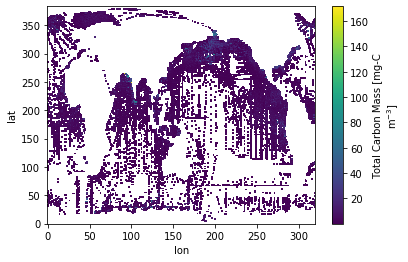

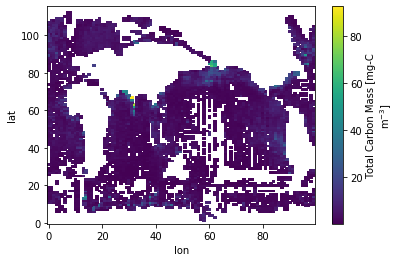

In [9]:
dso_lateral = xr.Dataset()

dso_lateral[v] = regrid_operator(dsann[v], renormalize=True)
dso_lateral[v].attrs = dsann[v].attrs
    
plt.figure()
dsann[v].plot()

plt.figure()
dso_lateral[v].plot();

### Apply missing values mask to the newly interpolated data
First make a mask

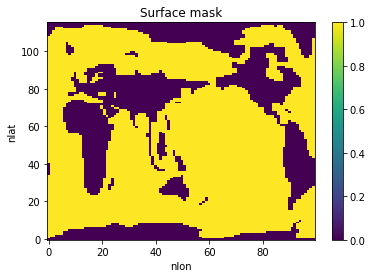

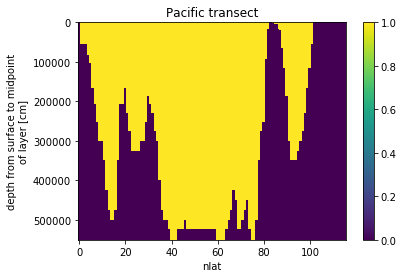

In [11]:
nk = len(ds_dst.z_t)
nj, ni = ds_dst.KMT.shape

# make 3D array of 0:km
zero_to_km = xr.DataArray(np.arange(0, nk), dims=('z_t'))
ONES_3d = xr.DataArray(np.ones((nk, nj, ni)), dims=('z_t', 'nlat', 'nlon'))
ZERO_TO_KM = (zero_to_km * ONES_3d)

# mask out cells where k is below KMT
MASK = ZERO_TO_KM.where(ZERO_TO_KM < ds_dst.KMT)
MASK = xr.where(MASK.notnull(), True, False)

MASK['z_t'] = ds_dst.z_t

plt.figure()
MASK.isel(z_t=0).plot()
h = plt.title('Surface mask')

plt.figure()
MASK.isel(nlon=60).plot(yincrease=False)
h = plt.title('Pacific transect')


Then apply the mask

In [13]:
dso_lateral[v] = dso_lateral[v].where(MASK)

In [ ]:
plt.figure()
dso_lateral[v].isel(z_t=0).plot()

plt.figure()
dso_lateral[v].isel(nlon=60).plot(yincrease=False)
h = plt.title('Pacific transect')

### Get the dataset ready to write out

In [27]:
dso = dso_lateral.copy()


dso[v].encoding['_FillValue'] = default_fillvals['f4']
dso[v].encoding['dtype'] = np.float32

if '_FillValue' not in dso[v].encoding:
    dso[v].encoding['_FillValue'] = None

datestamp = datetime.now(timezone.utc).strftime("%Y-%m-%d")
dso.attrs['history'] = f'created by kristen krumhardt on {datestamp}'

datestamp = date.today().strftime("%y%m%d")
dso

<xarray.Dataset>
Dimensions:         (nlat: 116, nlon: 100)
Dimensions without coordinates: nlat, nlon
Data variables:
    carbon_biomass  (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    history:  created by kristen krumhardt on 2020-11-03

In [28]:
#!ncdump -h /glade/work/kristenk/WOA_data/regrid_POP/WOA_POPgrid.nc

In [29]:
#file_out = f'{config.dirout}/marbl_jan_ic_woa_{dst_grid}.c{datestamp}.nc'
file_out = '/glade/work/kristenk/copepod_data/COPEPOD_m00_x3POPgrid.nc'
dso.to_netcdf(file_out)